In [1]:
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

# Online results

In [2]:
online_file_to_label = {
  'nipsA_wideNdeep_online.txt': 'Wide&Deep',
  'nipsA_deepfm_online.txt': 'DeepFM',
  'nipsA_pnn_online.txt': 'PNN',
  'nipsA_ipnn_online.txt': 'IPNN',
  'nipsA_opnn_online.txt': 'OPNN',
  'nipsA_gbdt_online.txt': 'GBDT',
  'nipsA_d1_online.txt': 'DeepGBM(D1)',
  'nipsA_gbdt2nn_online.txt': 'DeepGBM(D2)',
  'nipsA_deepgbm_online.txt': 'DeepGBM',
  'nipsA_deepgbm_offline.txt': 'DeepGBM(Off)',
}

In [3]:
def filter_results_for(lines, prefix, suffix):
  results = []
  for line in lines:
    if not (line.startswith(prefix) and line.endswith(suffix)):
      continue
    if prefix:
      line = line[len(prefix):]
    if suffix:
      line = line[:-len(suffix)]
    metrics_str = [metric.strip() for metric in line.split(',')]
    metrics = [float(metric_str) for metric_str in metrics_str]
    auc = metrics[-1]
    results.append(auc)
  return results

In [4]:
def get_label_to_results_online(results_dir, online_experiment_files):
  label_to_results = {}
  for experiment_file in online_experiment_files:
    label = online_file_to_label[experiment_file]
    path = os.path.join(results_dir, experiment_file)
    with open(path, 'r') as f:
      lines = f.readlines()
    lines = [line.strip() for line in lines]
    if label == 'GBDT':
      results = filter_results_for(lines, '(', ')')
    elif label == 'DeepGBM(Off)':
      results1 = filter_results_for(lines, 'Final Best Metric: ', '')
      assert len(results1) == 10
      results2 = filter_results_for(lines, 'Final metrics: (', ')')
      assert len(results2) == 20
      results = results2
      for i, result in enumerate(results1):
        if i % 2 != 0:
          results[4 * (i // 2)] = result
    else:
      results = filter_results_for(lines, 'Final Best Metric: ', '')

    if label in ['DeepGBM(D2)', 'DeepGBM']:
      # Drop every 1st and every 5 result for models with GBDT2NN, since it outputs the result for GBDT too.
      results = [result for i, result in enumerate(results) if i % 5 != 0]

    assert len(results) == 20
    results = np.array(results)
    results = np.reshape(results, (5, 4))
    label_to_results[label] = results
  return label_to_results

In [5]:
def plot_performance_online(label_to_results, title):
  fontsize = 16
  fig, ax = plt.subplots(figsize=(16, 12))
  xticks = list(range(1, 5))
  ax.set_xticks(xticks)
  ax.set_xticklabels(['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4'])
  plt.xticks(fontsize=fontsize)
  plt.ylabel('AUC', fontsize=fontsize)
  plt.yticks(fontsize=fontsize)
  plt.ylim((0.66, 0.74))
  markers = itertools.cycle(('D', 's', '^', 'x', 'P', 'p', 'h', 'X', 'o', 'd'))
  labels = []
  plots = []
  for label, results in label_to_results.items():
    assert results.shape == (5, 4)
    mean = np.mean(results, axis=0)
    print(label)
    print(mean)
    labels.append(label)
    params = {}
    if not label:
      params['color'] = 'white'
    params['marker'] = next(markers)
    plots.append(ax.plot(xticks, mean, **params)[0])
  plt.title(title)
  legend_left = ax.legend(plots[0:4], labels[0:4], loc='lower left', prop={'size': fontsize}, frameon=False)
  legend_center = Legend(ax, plots[4:8], labels[4:8], loc='lower center', prop={'size': fontsize}, frameon=False)
  ax.add_artist(legend_center)
  legend_right = Legend(ax, plots[8:12], labels[8:12], loc='lower right', prop={'size': fontsize}, frameon=False)
  ax.add_artist(legend_right)

## Paper results

In [6]:
online_experiment_files = [
  'nipsA_wideNdeep_online.txt',
  'nipsA_deepfm_online.txt',
  'nipsA_pnn_online.txt',
  'nipsA_ipnn_online.txt',
  'nipsA_opnn_online.txt',
  'nipsA_gbdt_online.txt',
  'nipsA_d1_online.txt',
  'nipsA_gbdt2nn_online.txt',
  'nipsA_deepgbm_online.txt',
  'nipsA_deepgbm_offline.txt'
]
label_to_results = get_label_to_results_online('results/online_scripts', online_experiment_files)

Wide&Deep
[0.70683883 0.70111035 0.70818179 0.71280048]
DeepFM
[0.70584834 0.69819002 0.7072641  0.71070621]
PNN
[0.69884049 0.70032199 0.71014046 0.71689041]
IPNN
[0.70174336 0.70420572 0.71132933 0.7188468 ]
OPNN
[0.69948817 0.69873512 0.70706268 0.71460084]
GBDT
[0.72201301 0.71925145 0.71694445 0.71327032]
DeepGBM(D1)
[0.72255628 0.72532905 0.72607789 0.72634499]
DeepGBM(D2)
[0.72663254 0.73165053 0.73192289 0.73023061]
DeepGBM
[0.725328   0.73200875 0.73199455 0.73198054]
DeepGBM(Off)
[0.725328   0.71115531 0.67601966 0.6308038 ]


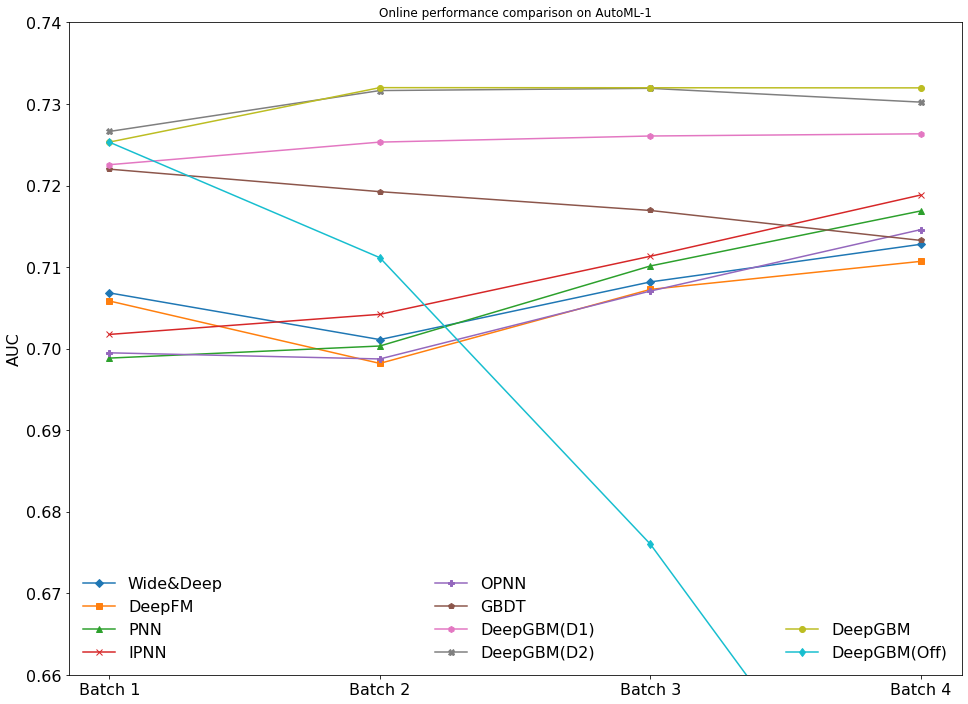

In [7]:
plot_performance_online(label_to_results, 'Online performance comparison on AutoML-1')

## Optimized tree splits

In [8]:
online_experiment_files = [
  'nipsA_wideNdeep_online.txt',
  'nipsA_deepfm_online.txt',
  'nipsA_pnn_online.txt',
  'nipsA_gbdt_online.txt',
  'nipsA_d1_online.txt',
  'nipsA_gbdt2nn_online.txt',
  'nipsA_deepgbm_online.txt',
  'nipsA_deepgbm_offline.txt'
]
label_to_results = get_label_to_results_online('results/optimized_online_scripts', online_experiment_files)

Wide&Deep
[0.70683883 0.70111035 0.70818179 0.71280048]
DeepFM
[0.70584834 0.69819002 0.7072641  0.71070621]
PNN
[0.69884049 0.70032199 0.71014046 0.71689041]
GBDT
[0.72201301 0.71925145 0.71694445 0.71327032]
DeepGBM(D1)
[0.72255628 0.72532905 0.72607789 0.72634499]
DeepGBM(D2)
[0.72661078 0.73083001 0.73211727 0.7306986 ]
DeepGBM
[0.72441194 0.73084259 0.73151829 0.73134928]
DeepGBM(Off)
[0.72506649 0.71069057 0.67508286 0.6303211 ]


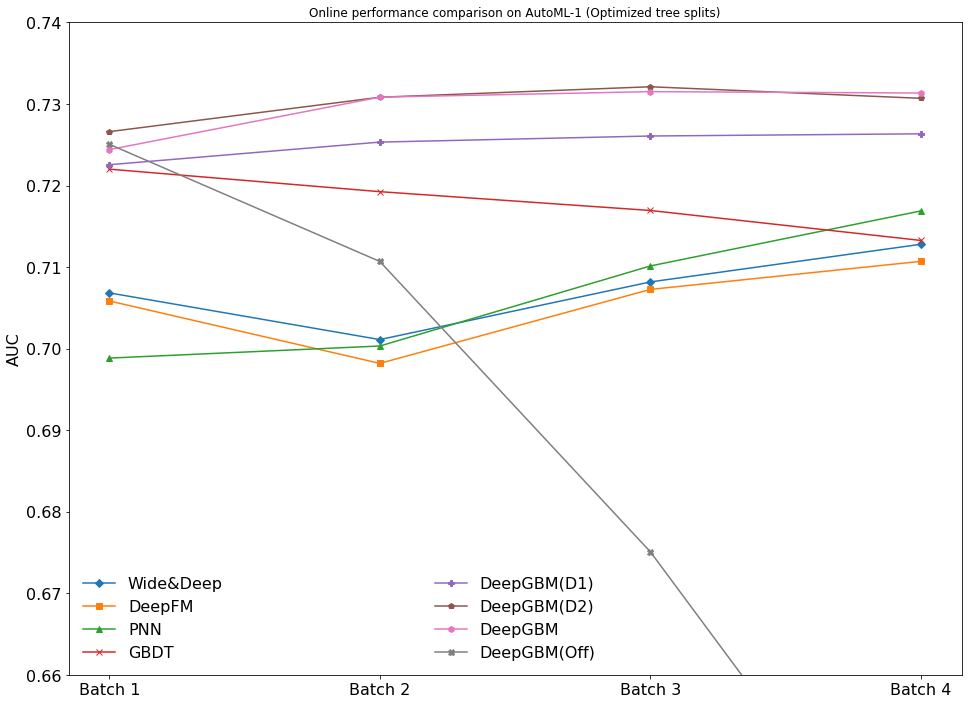

In [9]:
plot_performance_online(label_to_results, 'Online performance comparison on AutoML-1 (Optimized tree splits)')

# Offline results

In [10]:
import collections

EpochAuc = collections.namedtuple('EpochAuc', ['epoch', 'auc'])

def load_results_from_path(experiment_path):
  with open(experiment_path, 'r') as f:
    lines = f.readlines()
  lines = [line.strip() for line in lines]
  results = []
  for i, line in enumerate(lines):
    if line == 'Evaluate Result:':
      if not results:
        results.append([])
      nline = lines[i + 1]
      handle = 'Testing AUC: '
      handle_index = nline.find(handle)
      epoch = int(nline[6:9])
      auc = float(nline[handle_index+len(handle):handle_index+len(handle)+8])
      if results[-1] and results[-1][-1].epoch == epoch:
        # Testing during the same epoch => replace with the new score
        results[-1][-1] = EpochAuc(epoch, auc)
      else:
        if results[-1] and results[-1][-1].epoch > epoch:
          results.append([])
        results[-1].append(EpochAuc(epoch, auc))
        
  if not results:
    # GBDT training
    for line in lines:
      if line and line[0] == '(' and line[-1] == ')':
        epoch = 0
        metrics_str = [metric.strip() for metric in line[1:-1].split(',')]
        metrics = [float(metric_str) for metric_str in metrics_str]
        auc = metrics[-1]
        results.append([EpochAuc(-1, auc)])

  assert results
  return results

In [11]:
def plot_performance_offline(offline_line_to_label, results_dir, title):
  fontsize = 16
  fig, ax = plt.subplots(figsize=(16, 12))
  xticks = list(range(20))
  ax.set_xticks(xticks)

  markers = itertools.cycle(('D', 's', '^', 'x', 'P', 'p', 'h', 'X', 'o'))
  labels = []
  plots = []
  for experiment_file, label in offline_line_to_label.items():
    experiment_path = os.path.join(results_dir, experiment_file)
    results = load_results_from_path(experiment_path)
    epoch_to_aucs = collections.defaultdict(list)
    for run in results:
      for epoch, auc in run:
        epoch_to_aucs[epoch].append(auc)
    epoch_to_mean = {}
    for epoch, aucs in epoch_to_aucs.items():
      epoch_to_mean[epoch] = np.mean(aucs)
    epoch_means = list(sorted(epoch_to_mean.items()))
    epochs = [em[0] for em in epoch_means]
    means = [em[1] for em in epoch_means]
    # Handling the models without epochs
    if epochs == [-1]:
      epochs = xticks
      means = means * len(xticks)

    labels.append(label)
    params = {}
    params['marker'] = next(markers)
    plots.append(ax.plot(epochs, means, **params)[0])
    print(label)
    print(means)

  plt.title(title)
  legend = ax.legend(plots, labels, prop={'size': fontsize}, frameon=False)

## Paper results

In [12]:
offline_file_to_label = {
  'nipsA_lr_offline.sh': 'LR',
  'nipsA_fm_offline.sh': 'FM',
  'nipsA_wideNdeep_offline.sh': 'Wide&Deep',
  'nipsA_deepfm_offline.sh': 'DeepFM',
  'nipsA_pnn_offline.sh': 'PNN',
  'nipsA_gbdt_offline.sh': 'GBDT',
  'nipsA_d1_offline.sh': 'DeepGBM(D1)',
  'nipsA_gbdt2nn_offline.sh': 'DeepGBM(D2)',
  'nipsA_deepgbm_offline.sh': 'DeepGBM',
}

LR
[0.7276212, 0.7232664, 0.7160946, 0.707801, 0.7024001999999999, 0.6970916, 0.6925756, 0.6879706, 0.6856253999999999, 0.6829972, 0.6806364, 0.6792602000000001, 0.6770974, 0.6757332, 0.6743736, 0.6738942, 0.6723334, 0.6715519999999999, 0.6701189999999999, 0.6705714]
FM
[0.7308195999999999, 0.7247652, 0.7156170000000001, 0.7075495999999999, 0.7007004, 0.6941422000000002, 0.6899792, 0.6857046, 0.6837808000000001, 0.6821280000000002, 0.680285, 0.6780036, 0.6769368, 0.6742944000000001, 0.6744517999999999, 0.6725407999999999, 0.6722892, 0.6723684000000001, 0.6706945999999999, 0.6701121999999999]
Wide&Deep
[0.7408816, 0.7380677999999999, 0.7323274000000001, 0.7278222000000001, 0.723442, 0.7191922, 0.7157874, 0.7119668, 0.7113352, 0.7090802, 0.7063656, 0.7059554, 0.704, 0.7029256, 0.7012065999999999, 0.7000746, 0.698959, 0.6970295999999999, 0.6967268, 0.6963348]
DeepFM
[0.7399647999999999, 0.7368792, 0.729357, 0.722579, 0.716301, 0.7105072, 0.7055904, 0.7020894, 0.7009801999999998, 0.6979678

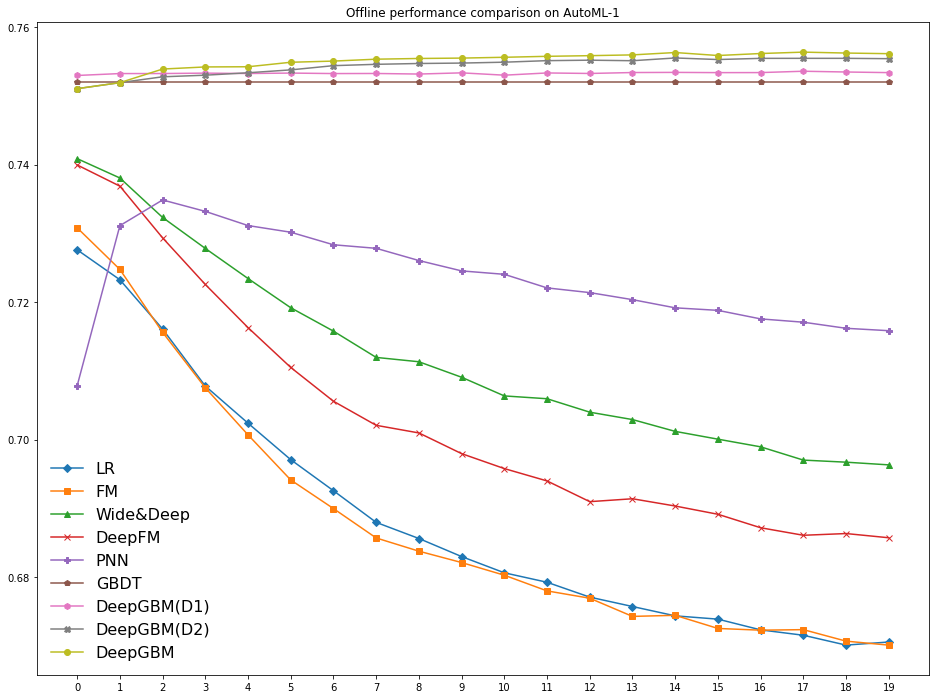

In [13]:
plot_performance_offline(
  offline_file_to_label,
  'results/offline_scripts',
  'Offline performance comparison on AutoML-1')

## Optimized tree splits

LR
[0.7276212, 0.7232664, 0.7160946, 0.707801, 0.7024001999999999, 0.6970916, 0.6925756, 0.6879706, 0.6856253999999999, 0.6829972, 0.6806364, 0.6792602000000001, 0.6770974, 0.6757332, 0.6743736, 0.6738942, 0.6723334, 0.6715519999999999, 0.6701189999999999, 0.6705714]
FM
[0.7308195999999999, 0.7247652, 0.7156170000000001, 0.7075495999999999, 0.7007004, 0.6941422000000002, 0.6899792, 0.6857046, 0.6837808000000001, 0.6821280000000002, 0.680285, 0.6780036, 0.6769368, 0.6742944000000001, 0.6744517999999999, 0.6725407999999999, 0.6722892, 0.6723684000000001, 0.6706945999999999, 0.6701121999999999]
Wide&Deep
[0.7408816, 0.7380677999999999, 0.7323274000000001, 0.7278222000000001, 0.723442, 0.7191922, 0.7157874, 0.7119668, 0.7113352, 0.7090802, 0.7063656, 0.7059554, 0.704, 0.7029256, 0.7012065999999999, 0.7000746, 0.698959, 0.6970295999999999, 0.6967268, 0.6963348]
DeepFM
[0.7399647999999999, 0.7368792, 0.729357, 0.722579, 0.716301, 0.7105072, 0.7055904, 0.7020894, 0.7009801999999998, 0.6979678

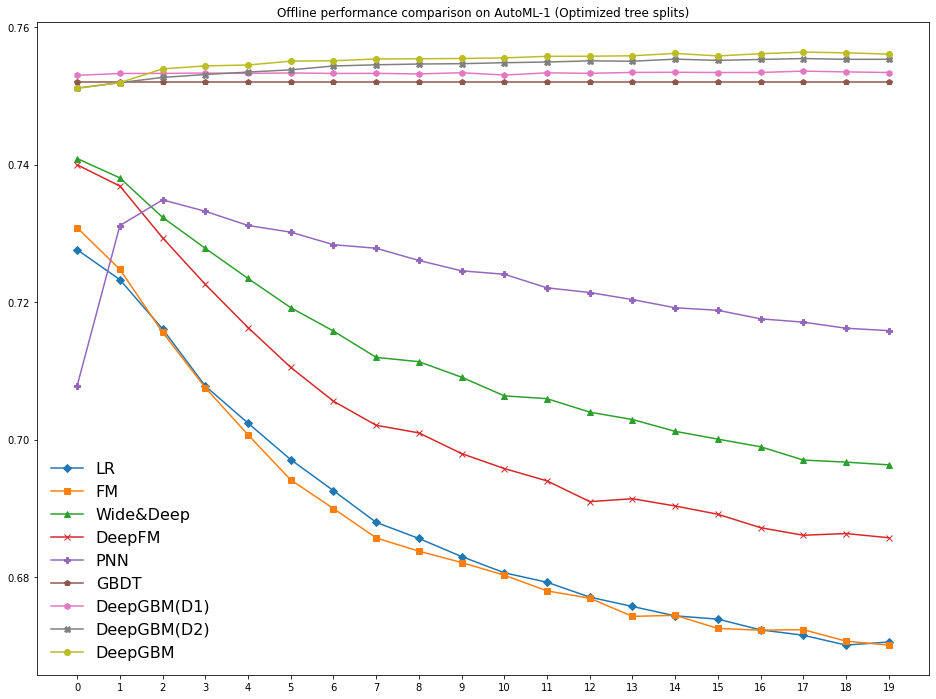

In [14]:
plot_performance_offline(
  offline_file_to_label,
  'results/optimized_offline_scripts',
  'Offline performance comparison on AutoML-1 (Optimized tree splits)')